In [ ]:
# Notebook for simulating, saving and analysing MOMA-like data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import subprocess

## Functions for simulating cells 

In [2]:

class Cell:
    def __init__(self, log_length0, gfp0, lambda0, q0, time0=0., cell_id = 0, parent_id=-1):
        self.parent_id = parent_id
        self.cell_id = cell_id
        self.length = [np.exp(log_length0)]  # s(t)
        self.log_length = [log_length0]      # x(t) = x0 + int lambda dt
        self.gfp = [gfp0]
        self.time = [time0]
        self.qt = [q0]
        self.lambda_t = [lambda0]

    def to_df(self, n=1):
        return pd.DataFrame({   "cell_id": ([self.cell_id]*len(self.time))[::n],
                                "time_min": self.time[::n],
                                "parent_id": ([self.parent_id]*len(self.time))[::n],
                                "log_length": self.log_length[::n], 
                                "gfp": self.gfp[::n]})

def df2cells(dataset, noise=False):
    """ 
    dataset (pandas data frame as read from csv file) to list of Cell instances 
    either using columns with measurment noise or without
    """
    cell_list = []
    last_cell = ""

    if noise:
        gfp = "gfp_noise"
        log_length = "log_length_noise"
    else: 
        gfp = "gfp"
        log_length = "log_length"

    for index, row in dataset.iterrows(): 
        if row["cell_id"] != last_cell:
            new_cell = Cell(row[log_length], row[gfp], 0, 0, time0=row["time_min"],
                            cell_id=row["cell_id"], 
                            parent_id=row["parent_id"])
            cell_list.append(new_cell)
        else:
            cell_list[-1].log_length.append(row[log_length])
            cell_list[-1].gfp.append(row[gfp])
            cell_list[-1].time.append(row["time_min"])

        last_cell = row["cell_id"]
    return cell_list

# =============== Simulation functions ===============#

def single_ou_step(dt, mean, gamma, var, x):
    noise = np.sqrt(var) * np.random.normal(loc=0, scale=1) * np.sqrt(dt)
    return x - gamma*(x-mean)*dt + noise

def growth(cell, dt, lambda_t):  
    # calculate next step
    next_step = cell.log_length[-1] + lambda_t*dt

    # save everything
    cell.lambda_t.append(lambda_t)
    cell.log_length.append(next_step)
    cell.length.append(np.exp(next_step))
    return cell

def gfp_production(cell, dt, qt, beta):
    # calculate next step
    next_step = cell.gfp[-1] + cell.length[-1]*qt*dt - cell.gfp[-1]*beta*dt   

    cell.qt.append(qt)
    cell.gfp.append(next_step)
    return cell 

def cell_divsion(cell, var_dx, var_dg, no_cells):

    cell1 = Cell(np.random.normal(loc=cell.log_length[-1] - np.log(2), scale=np.sqrt(var_dx)),
                    np.random.normal(loc=cell.gfp[-1]/2, scale=np.sqrt(var_dg)), cell.lambda_t[-1], cell.qt[-1],
                    time0 = cell.time[-1],
                    cell_id = no_cells + 1, parent_id=cell.cell_id)

    cell2 = Cell(np.random.normal(loc=cell.log_length[-1] - np.log(2), scale=np.sqrt(var_dx)),
                    np.random.normal(loc=cell.gfp[-1]/2, scale=np.sqrt(var_dg)), cell.lambda_t[-1], cell.qt[-1], 
                    time0 = cell.time[-1],
                    cell_id = no_cells + 2, parent_id=cell.cell_id)
    # print(cell1.cell_id, cell.time[-1], cell1.log_length[0], cell.log_length[-1])
    # print(cell2.cell_id, cell.time[-1], cell2.log_length[0], cell.log_length[-1])

    # _cell_div.append( [cell1.log_length[0] - cell.log_length[-1] + np.log(2) ,  cell1.gfp[0] - cell.gfp[-1]/2 ])
    # _cell_div.append( [cell2.log_length[0] - cell.log_length[-1] + np.log(2) ,  cell2.gfp[0] - cell.gfp[-1]/2 ])

    no_cells += 2 
    return cell1, cell2, no_cells

def is_cell_division(cell, mode, division_log_length, division_time, division_addition):
    if mode == "timer":
        if cell.time[-1] - cell.time[0] > division_time:
            return True
        else: 
            return False
    if mode == "sizer":
        if cell.log_length[-1] > division_log_length:
            return True
        else: 
            return False
    if mode == "adder":
        if cell.log_length[-1] - cell.log_length[0] > division_addition:
            return True

# ============= FULL SIMULATION ============= # 

def simulate_cells(dt, n_cells, parameter_set, div_mode, division_log_length=None, division_time=None, division_addition=None):
    gfp0 = 3*parameter_set['mean_q']/parameter_set['mean_lambda']
    cell_queue = [Cell(division_log_length-np.log(2), gfp0, parameter_set['mean_lambda'], parameter_set['mean_q'])]
    cells_simulated = []
    no_cells = 0   # total number of cells (in queue and calculated)

    while len(cells_simulated) < n_cells:
        if len(cells_simulated)>0:
            idx = get_current_leafs_idx(cell_queue, cells_simulated)
            cell_index = np.random.choice(idx)
        else:
            cell_index = 0

        # print_simulated(cells_simulated)
        # print_queue(cell_queue,cell_index)

        # simulate a random cell in queue
        cell = copy.deepcopy(cell_queue[cell_index])

        # --------------------------------------------------------------- #
        # Simulation on single cell level
        # --------------------------------------------------------------- #
        while True:
            cell.time.append(cell.time[-1]+dt)

            q_ou = single_ou_step(dt,   parameter_set['mean_q'], 
                                        parameter_set['gamma_q'], 
                                        parameter_set['var_q'], 
                                        cell.qt[-1]) 

            cell = gfp_production(cell, dt, q_ou, parameter_set['beta'])

            lambda_ou = single_ou_step(dt,  parameter_set['mean_lambda'], 
                                            parameter_set['gamma_lambda'], 
                                            parameter_set['var_lambda'], 
                                            cell.lambda_t[-1]) 
            cell = growth(cell, dt, lambda_ou)
            if is_cell_division(cell, div_mode, division_log_length, division_time, division_addition):
                # save the simulated cell
                cells_simulated.append(cell)
                
                # calc. new init conditions for 2 daugter cells
                cell1, cell2, no_cells = cell_divsion(cell, parameter_set['var_dx'], 
                                                            parameter_set['var_dg'], 
                                                            no_cells)

                # remove the simulated cell from queue and add the new ones 
                cell_queue.pop(cell_index)
                cell_queue.append(cell1)
                cell_queue.append(cell2)
                break
            else:
                pass
        progress_bar_n = np.around(len(cells_simulated)/n_cells*20).astype(int)
        progress_bar = '='*progress_bar_n + ' '*(20-progress_bar_n)

        print("\r|", progress_bar,  "| Progress {:3.0f}%".format(len(cells_simulated)/n_cells*100), " No of cells: ", len(cells_simulated), end='')  
    print('')
    return cells_simulated


# =============== Helper functions ===============#

def print_queue(cell_queue, cell_index):
    print('In queue (total=', len(cell_queue), ')', end=' ', sep='')
    for i in range(len(cell_queue)):
        if i == cell_index:
            print('|', cell_queue[i].cell_id, '<-',  cell_queue[i].parent_id ,'|', end=' ', sep='')
        else:
            print(cell_queue[i].cell_id, end='  ', sep='')
    print('')

def print_simulated(cells_simulated):
    print('Simulated:', end=' ')
    for i in range(len(cells_simulated)):
        print(cells_simulated[i].cell_id, end=' ', sep='')
    print('')

def get_ids(cell):
    id_list = []
    for i in range(len(cell)):
        id_list.append(cell[i].cell_id)
    return id_list

def get_current_leafs_idx(cell_queue, cells_simulated):
    sim_ids = get_ids(cells_simulated)
    idx = []
    for i in range(len(cell_queue)):
        if cell_queue[i].parent_id in sim_ids:
            idx.append(i)
    return idx
        

## Functions for building and saving data set 

In [3]:
def mk_mising_dir(path_name):
    if not os.path.exists(path_name):
        os.mkdir(path_name)
    return path_name

def get_next_file_name(out_dir, no=None):
    sample = out_dir.split('/')[-1]
    if no != None:
        new_dir = os.path.join(out_dir, sample+"_{:d}".format(no),'')
        new_file = os.path.join(new_dir, sample+"_{:d}".format(no)+".csv")
        return new_dir, new_file

    for i in range(1000):
        new_dir = os.path.join(out_dir, sample+"_{:d}".format(i),'')
        new_file = os.path.join(new_dir, sample+"_{:d}".format(i)+".csv")
        if not os.path.isdir(new_dir):
            os.mkdir(new_dir)
            return new_dir, new_file

def write_param_file(filename, parameters, non_default={}):
    with open(filename, "w") as fin:
        fin.write("# Generated config file for simulated data\n")
        for k, v in parameters.items():
            if k in non_default:
                if non_default[k][0] == "fixed":
                    fin.write("{:s} = {:.2E}\n".format(k, v))
                else:
                    fin.write("{:s} = {:.2E}, {:.2E}, {:.2E}, {:.2E}\n".format(k,   v*non_default[k][0],    
                                                                                        v*non_default[k][1], 
                                                                                        v*non_default[k][2], 
                                                                                        v*non_default[k][3] ))
            else:
                if v==0:
                    fin.write("{:s} = {:.2E}, {:.2E}\n".format(k, v, 1e-3)) 
                else:
                    fin.write("{:s} = {:.2E}, {:.2E}, {:.2E}, {:.2E}\n".format(k, v, v*1e-2, v*0.5, v*5. ))

def write_csv_config(filename):
    with open(filename, "w") as fin:
        fin.write("# Generated config file for simulated data\n")
        fin.write("time_col = time_min  \n")
        fin.write("length_col = log_length_noise \n")
        fin.write("length_islog = true \n")
        fin.write("fp_col = gfp_noise \n")
        fin.write("parent_tags = parent_id \n")
        fin.write("cell_tags = cell_id \n")
        fin.write("divide_time = 1 \n")

def build_data_set(cells_simulated, var_x, var_g, n):
    print("Every", n, "th datapoint is saved")
    dataset = pd.DataFrame()
    for i in range(len(cells_simulated)):
        next_celldf = cells_simulated[i].to_df(n)
        next_celldf['log_length_noise'] = next_celldf['log_length'] + np.random.normal(loc=np.zeros_like( next_celldf['log_length']), scale=np.sqrt(var_x))
        next_celldf['gfp_noise'] = next_celldf['gfp'] + np.random.normal(loc=np.zeros_like( next_celldf['gfp']), 
                                                                        scale=np.sqrt(var_g))
        dataset = dataset.append(next_celldf)

    return dataset


def suggest_run_command(directory, filename):
    return "../bin/gfp_gaussian -c " + os.path.join(directory, "csv_config.txt") +  " -b " + os.path.join(directory, "parameters.txt") + " -r 1e-3  -i " + filename + " -l 0 -s -m -p"


## Simulation with cell tree

In [4]:
# ========== Simulation parameters ========== #
out_dir = mk_mising_dir('../data/var_dg_timer_cells')
save_dataset = False    # saves data set as csv
run_ggp = False         # runs the ggp code (located in "../bin/" relative to this nb)

dt = 1e-3
dt_measument = 3 # in minutes
n_cells = 10 # number of cells that will be simulated

div_mode = "timer"
division_log_length = 1+np.log(2)   # for sizer: division, when log_length hits division_log_length
division_time = 60 - 1e-10          # for timer: division, when cell cycle time hits division_time
division_addition = np.log(2)       # for adder: divsion, when division_addition in log_length was added in cell cycle

# for var_dg in [10,50,100,500,1000,5000]:
for var_dg in [10]:
    # ========== Model parameters ========== #
    parameter_set = {   "mean_lambda": 0.01, 
                        "gamma_lambda": 0.01,
                        "var_lambda": 1e-7,
                        "mean_q": 10,
                        "gamma_q": 1e-2,
                        "var_q": 0.1,
                        "beta": 0.001, #1e-3,
                        "var_x": 1e-3,
                        "var_g": 5000,
                        "var_dx": 0.001,
                        "var_dg": var_dg}

    # --------- SIMULATE --------- #
    cells_simulated = simulate_cells(dt, n_cells, parameter_set, div_mode,
                         division_log_length, 
                         division_time, 
                         division_addition)

    dataset = build_data_set(cells_simulated, parameter_set['var_x'], parameter_set['var_g'], int(dt_measument/dt))

    # ----------- SAVE ----------- #
    if save_dataset:
        directory, filename = get_next_file_name(out_dir)

        # don't use default bounds for var_dg               
        write_param_file(os.path.join(directory, "parameters.txt"), 
                        parameter_set) 

        write_csv_config(os.path.join(directory, "csv_config.txt"))
        dataset.to_csv(filename)
        print("New simulation saved in", filename)

    # ----------- RUN ----------- #
        if run_ggp:
            run_cmd = suggest_run_command(directory, filename)
            print("run: -> \n", run_cmd)
            s = subprocess.run(run_cmd, capture_output=False, shell=True)
            print(s)
        

| ==================== | Progress 100%  No of cells:  10
Every 3000 th datapoint is saved


### Plot simulated data
- plots the cells with the last simulated parameter set

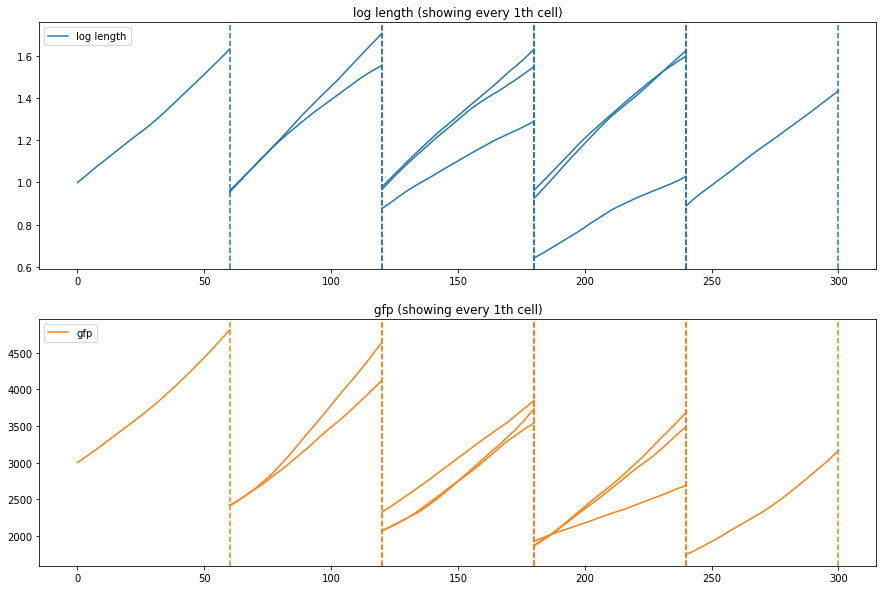

In [5]:
def plot_cells(cells, n_steps=1):
    fig, axes = plt.subplots(2, figsize=(15,10))
    ax = axes.ravel()

    for j in range(len(cells[::n_steps])):
        cell = copy.deepcopy(cells[j])
        cell.time = np.array(cell.time)

        ax[0].set_title("log length (showing every {:d}th cell)".format(n_steps))
        ax[1].set_title("gfp (showing every {:d}th cell)".format(n_steps))
        # ax[0].set_ylim([1.2, 2.2])
        
        if len(cells_simulated) <20:
            ax[0].axvline(cell.time[-1], ls='--', color='tab:blue')
            ax[1].axvline(cell.time[-1], ls='--', color='tab:orange')

        if j ==0:
            ax[0].plot(cell.time, np.array(cell.log_length), label='log length', color='tab:blue')
            ax[1].plot(cell.time, np.array(cell.gfp), color='tab:orange', label='gfp')

        else:
            ax[0].plot(cell.time, np.array(cell.log_length), color='tab:blue')
            ax[1].plot(cell.time, np.array(cell.gfp), color='tab:orange')

    for j in range(2):
        ax[j].legend()

plot_cells(cells_simulated)


In [6]:
# from treelib import Node, Tree

# tree = Tree()
# for i in range(len(cells_simulated)):
#     if cells_simulated[i].parent_id>=0:
#         tree.create_node(cells_simulated[i].cell_id,  cells_simulated[i].cell_id, parent=cells_simulated[i].parent_id)
#     else:
#         tree.create_node(cells_simulated[i].cell_id,  cells_simulated[i].cell_id)
# tree.show()

## Analyse simulated data

In [9]:
# cell_list_df = df2cells(dataset)

In [10]:
# def get_cell_from_id(cell_list, cell_id):
#     for cell in cell_list:
#         if cell.cell_id == cell_id:
#             return cell

# def cell_division_stats(cell_list):
#     dx = []
#     dg = []
#     for cell in cell_list:
#         if cell.parent_id != -1:
#             parent_cell = get_cell_from_id(cell_list, cell.parent_id)
#             dx.append(parent_cell.log_length[-1] - cell.log_length[0] - np.log(2))
#             dg.append(parent_cell.gfp[-1]/2 - cell.gfp[0])
#             # print(cell.cell_id, parent_cell.time[-1], cell.log_length[0], parent_cell.log_length[-1], dx[-1])
#     return dx, dg


# dx, dg = cell_division_stats(cell_list_df)
# fig, ax = plt.subplots(2,1)

# ax[0].hist(dx, color='tab:blue')
# ax[1].hist(dg, color='tab:orange')

# plt.show()





## Cecking dt dependence 

| ==================== | Progress 100%  No of cells:  100
| ==================== | Progress 100%  No of cells:  100
| ==================== | Progress 100%  No of cells:  100
| ==================== | Progress 100%  No of cells:  100


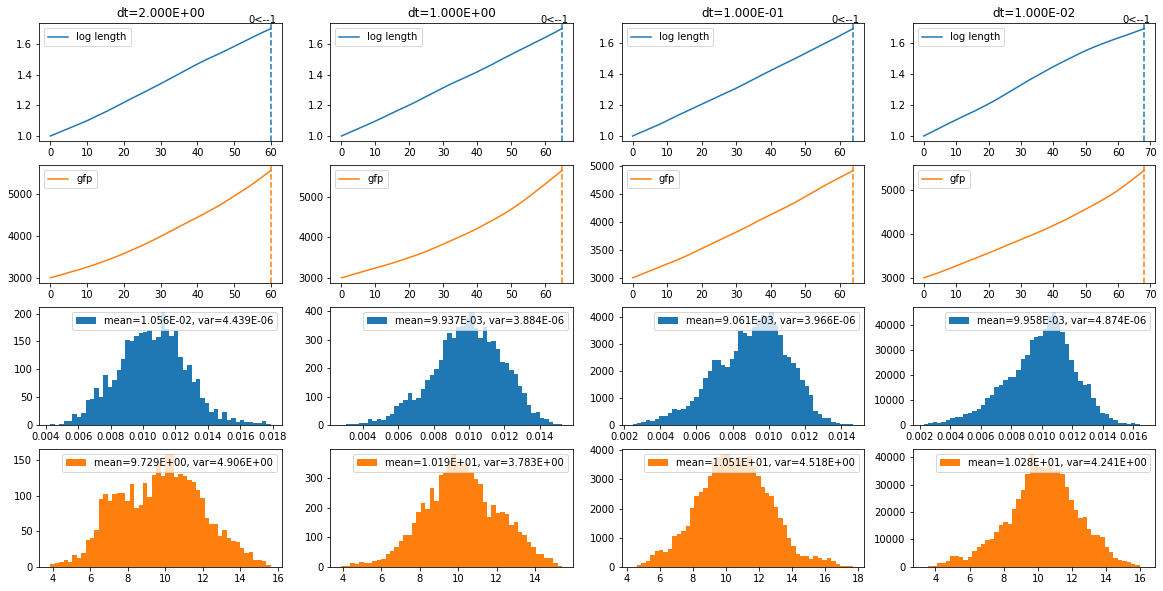

In [13]:
div_mode = "sizer"
division_log_length = 1+np.log(2)

# ========== Model parameters ========== #
parameter_set = {   "mean_lambda": 0.01, 
                    "gamma_lambda": 0.01,
                    "var_lambda": 1e-7,
                    "mean_q": 10,
                    "gamma_q": 1e-2,
                    "var_q": 0.1,
                    "beta": 0.001, #1e-3,
                    "var_x": 1e-3,
                    "var_g": 5000,
                    "var_dx": 0.001,
                    "var_dg": 50}

n_cells = 100
dt_list = [2, 1,0.1, 0.01]

fig, ax = plt.subplots(4,len(dt_list), figsize=(20,10))

for i, dt in enumerate(dt_list):
    cell_list = simulate_cells(dt, n_cells, parameter_set, div_mode, division_log_length)

    for j in range(1):
        cell = cell_list[j]
        cell.time = np.array(cell.time)
        cell_list.append(copy.deepcopy(cell))

        ax[0,i].set_title("dt={:.3E}".format(dt))
        ax[0,i].text(cell.time[-1]*0.9, cell.log_length[-1]*1.02, '{:d}<-{:d}'.format(cell.cell_id, cell.parent_id))

        ax[0,i].axvline(cell.time[-1], ls='--', color='tab:blue')
        ax[1,i].axvline(cell.time[-1], ls='--', color='tab:orange')

        if j ==0:
            label_len = 'log length'
            label_gfp = 'gfp'
        else:
            label_len = None
            label_gfp = None

        ax[0,i].plot(cell.time, np.array(cell.log_length), label=label_len, color='tab:blue')
        ax[1,i].plot(cell.time, np.array(cell.gfp), label=label_gfp, color='tab:orange')

    lts = []
    qts = []
    for cell in cell_list:
        lts += cell.lambda_t
        qts += cell.qt

    ax[2,i].hist(lts, color='tab:blue', bins=50, label = 'mean={:.3E}, var={:.3E}'.format(np.mean(lts), np.var(lts)))
    ax[3,i].hist(qts, color='tab:orange', bins=50, label = 'mean={:.3E}, var={:.3E}'.format(np.mean(qts), np.var(qts)))

    for j in range(np.shape(ax)[0]):
        ax[j,i].legend()

plt.show()